In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import datetime
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras import ops
from keras import layers, models
from keras import backend as K
from keras.callbacks import TensorBoard
from PIL import Image
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
# Connexion Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd drive/MyDrive/Colab Notebooks/data_sample_10000

/content/drive/MyDrive/Colab Notebooks/data_sample_10000


In [4]:
def format_img(id):
    '''

    Parameters
    ----------
    The identifier of the image to load


    Returns
    -------
    The image cropped and resized in a numpy array of shape (128, 128, 3)

    '''
     # Load the image and turn it into a numpy array
    image = Image.open(f'./{id}.jpg')

    """
    #Size of the original image
    width, height = image.size

    # Normalization of the image
    # The image is centered and cropped to widthxwidth format
    left = 0
    top = (height/2)-(width/2)
    right = width
    bottom = (height/2)+(width/2)
    """

    image = image.crop((0, 20, 178, 198))

    # Change of resolution to 128x128
    img_resized = image.resize((128, 128))

    # -1 to flatten, 3 for RGB channels
    image_np = np.array(img_resized) # do not flatten

    return image_np

In [6]:
def import_data():
  data=[]

  for i in range(1, 1001):
      id = f"{i:06}"  # Format the ID with 5 numbers, filled with zeroes on the left side
      data.append(format_img(id))
      if i%100==0:
          print(id)


  data=np.array(data)
  print(data.shape)

  # Normalization of the pixels
  data=data/255

  return data


In [7]:
data=import_data()

000100
000200
000300
000400
000500
000600
000700
000800
000900
001000
(1000, 128, 128, 3)


In [8]:
# Allows you to choose an attribute by name
attributes_names = np.genfromtxt("list_attr_celeba.txt", dtype=str, skip_header=1, max_rows=1)
print(attributes_names)

my_attribute='Male'

index = np.where(attributes_names == f"{my_attribute}")[0]  # Return index table
print(index)
my_index=index[0]+1
print(my_index)

['5_o_Clock_Shadow' 'Arched_Eyebrows' 'Attractive' 'Bags_Under_Eyes'
 'Bald' 'Bangs' 'Big_Lips' 'Big_Nose' 'Black_Hair' 'Blond_Hair' 'Blurry'
 'Brown_Hair' 'Bushy_Eyebrows' 'Chubby' 'Double_Chin' 'Eyeglasses'
 'Goatee' 'Gray_Hair' 'Heavy_Makeup' 'High_Cheekbones' 'Male'
 'Mouth_Slightly_Open' 'Mustache' 'Narrow_Eyes' 'No_Beard' 'Oval_Face'
 'Pale_Skin' 'Pointy_Nose' 'Receding_Hairline' 'Rosy_Cheeks' 'Sideburns'
 'Smiling' 'Straight_Hair' 'Wavy_Hair' 'Wearing_Earrings' 'Wearing_Hat'
 'Wearing_Lipstick' 'Wearing_Necklace' 'Wearing_Necktie' 'Young']
[20]
21


In [9]:
attributes = np.loadtxt("list_attr_celeba.txt", skiprows=2, dtype='str')
attributes_short = attributes[0:1000]
genre = np.array(attributes_short[:,my_index], dtype=int)
unique, counts = np.unique(genre, return_counts=True)
unique = map(str, unique)
counts = map(int, counts)
headcounts=dict(zip(unique, counts))

# Allows you to see if the distribution of the attribute is balanced
print(f"{my_attribute} repartition {headcounts}")

Male repartition {'-1': 568, '1': 432}


In [168]:
from keras import Model, Input

def build_encoder(input_shape=(128, 128, 3)):
    '''

    Parameters
    ----------
      - The image of shape (128,128,3)

    Details
    -------
    The encoder (CNN) is structured as followed:
    1. Treatment of the image: extracting the image features
      - 2 Conv2D layers using 32 filters of size 3x3, with a stride of 1 to extract basic characteristics from each pixel of the image.
      - 1 MaxPooling layer using a filter of size 2x2, with a stride of 2 to reduce the size of feature map while preserving the most important information.
      - 2 more 2 Conv2D layers of 64 and 128 filters, followed alternately by MaxPooling layers
      - 1 flatten layer to flatten the multidimensional data into a 1D vector.

    2. Treament of the label:
      - 1 Dense layer with 64 neurons which transforms it into a more compact shape. The label is then resized.

    3. Concatenation into a single layer:
      - This concatenation takes place just before the dense layers that produce the latent variables.
      - 1 dense (or fully connected) layer with 512 neurons.

    Then there is a variational part:
      - 2 dense layers perform a linear transformation to combine the 512 values and project them into a latent_dim dimension space using weight and bias.
      1 layer generate the mean of the latent distribution, the other generate the log-variance
      - 1 Lambda layer is used to limit the values of log-variance in the range [-10.0, 10.0] and to prevent them from becoming too large or too small,
      which could affect model stability during training.

    Then it use the function Sampling() to create a sample from the latent distribution using the previous mean, log_variance and an additionl noise.

    Returns
    -------
    A keras Model able to encode an image of shape (128,128,3) into a latent vector of size latent_dim


    '''
    img_input = Input(shape=input_shape, name="encoder_image_input")
    label_input = Input(shape=(1,), name="encoder_label_input")

    x = layers.Conv2D(32, 3, activation="relu", strides=1, padding="same")(img_input)
    x = layers.Conv2D(32, 3, activation="relu", strides=1, padding="same")(x)
    x = layers.MaxPooling2D(2,2)(x) #2x2 kernel size. Test with Conv2D kernel size = 2, stride 2 and no padding
    x = layers.Conv2D(64, 3, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2D(64, 3, activation="relu", strides=1, padding="same")(x)
    x = layers.MaxPooling2D(2,2)(x)
    x = layers.Conv2D(128, 3, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2D(128, 3, activation="relu", strides=1, padding="same")(x)
    x = layers.MaxPooling2D(2,2)(x)
    x = layers.Flatten()(x)

    # Dense layer to treat the label
    y = layers.Dense(64, activation="relu")(label_input)
    y = layers.Reshape((64,))(y)  # Make sur the label shape is (64,)

    # Late concatenation of label with image characteristics
    z = layers.Concatenate()([x, y])
    # Dense layer to generate the latent vector
    z = layers.Dense(512, activation="relu")(z)

    z_mean = layers.Dense(latent_dim, name="z_mean")(z)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(z)
    z_log_var = layers.Lambda(lambda t: tf.clip_by_value(t, -10.0, 10.0))(z_log_var)



    # Sampling layer
    def sampling(args):
        z_mean, z_log_var = args
        eps = tf.random.normal(shape=(tf.shape(z_mean)[0], latent_dim))
        return z_mean + tf.exp(0.5 * z_log_var) * eps

    z = layers.Lambda(sampling, output_shape=(latent_dim,), name="z")([z_mean, z_log_var])
    gender_logits = layers.Dense(1, activation="tanh")(z)  # output interval [-1, 1]


    encoder = Model([img_input, label_input], [z_mean, z_log_var, z, gender_logits], name="encoder")
    return encoder

In [170]:
def build_decoder(output_shape=(128, 128, 3)):
    '''

    Parameters
    ----------
      - The latent vector of size latent_dim

    Details
    -------
    The decoder is structured as followed:

    1. Treatment of the label:
      - 1 dense layer to transform it into a compact vector
      - 1 reshape layer to ensure it has the right shape

    2. Concatenation of label with latent vector:
      - 1 dense layer to extract information from the latent vector into a 1D vector of size 16 384 (8*8*256)
      - 1 reshape layer to reshape the vector to the shape (8, 8, 256). This corresponds to a "features map" of size 8x8 with 256 channels.
      This format is necessary to apply the following transposed convolution operations in the rest of the network.
      - 4 transposed convolution layers to increase the size of the image (doubling the width and height) while gradually reducing the number of channels (256 -> 128 -> 64 -> 32 -> 16)
      - One last transposed convolution layer generates the output image. It uses 3 filters, which corresponds the 3 channels of a RGB image.
      The sigmoid activation function is used here because it produces values between 0 and 1, to keep a normalized image.


    Returns
    -------
    A keras Model able to decode a latent vector of size latent_dim into an image of shape (128, 128, 3)

    '''
    latent_input = Input(shape=(latent_dim,), name="decoder_latent_input")
    label_input = Input(shape=(1,), name="decoder_label_input")

    # Label treatment
    y = layers.Dense(64, activation="relu")(label_input)  # Dense layer for label
    y = layers.Reshape((64,))(y)  # Reshape the label

    # Put latent and label together
    x = layers.Concatenate()([latent_input, y])
    x = layers.Dense(8 * 8 * 256, activation="relu")(x)
    x = layers.Reshape((8, 8, 256))(x)

    x = layers.Conv2DTranspose(128, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(16, 3, strides=2, padding="same", activation="relu")(x)

    output_img = layers.Conv2DTranspose(output_shape[2], 3, activation="sigmoid", padding="same")(x)

    decoder = Model([latent_input, label_input], output_img, name="decoder")
    return decoder

In [171]:
class CVAE(keras.Model):
    def __init__(self, encoder, decoder, variational=False, **kwargs):
        '''

        Parameters
        ----------
          - The encoder and decoder models that the CVAE model will use to encode the input data and reconstruct it.
          - variational: a boolean optional argument which determines whether the model will be a classic VAE or a CVAE with loss KL.
            If variational=True, KL loss will be calculated in addition to the reconstruction loss.
          - **kwargs: allows to pass other arguments (such as data) to the parent class constructor keras. Model.


        Returns
        -------
        The image cropped and resized in a numpy array of shape (128, 128, 3)

        '''
        super(CVAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")


       # Initialization of the attribute 'variational' to control KL loss
        self.variational = variational
        if self.variational:
            self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        else:
            self.kl_loss_tracker = None  # No KL loss if 'variational' is False



    @property
    def metrics(self):
          # Returns the metrics depending on whether KL is used or not
        metrics = [self.total_loss_tracker, self.reconstruction_loss_tracker]
        if self.variational and self.kl_loss_tracker is not None:
            metrics.append(self.kl_loss_tracker)
        return metrics

    def train_step(self, data):
        images, labels = data
        with tf.GradientTape() as tape:
            # Encoding
            z_mean, z_log_var, z, gender_logits = self.encoder([images, labels])
            # Decoding
            reconstruction = self.decoder([z, labels])

            # reconstruction_loss (MSE) computation
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_mean(
                    keras.losses.mean_squared_error(images, reconstruction), axis=(1, 2)
                )
            )

            # KL loss computation if 'variational' is True
            # The KL loss is calculated as the Kullback-Leibler divergence
            # between the approximate distribution (defined by z_mean and z_log_var) and a standard normal distribution
            if self.variational:
              kl_loss = -0.5 * tf.reduce_mean(
                  tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
                  )
              labels = tf.cast(labels, tf.float32)
              # Add gender_loss as a study factor
              gender_loss = tf.reduce_mean(tf.square(gender_logits - labels))  # labels: -1/1
              # The weights of the kl_loss and gender_loss could be modified
              total_loss = reconstruction_loss + 0.1 * kl_loss + 0.01 * gender_loss
              self.kl_loss_tracker.update_state(kl_loss)  # Update of KL loss
            else:
                total_loss = reconstruction_loss



        # Gradients computation and weights update
        #  The gradients of the total loss versus the model weights are calculated and used to update the weights via the optimizer.
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # Metrics update
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)


        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result() if self.variational else 0.0,
            "gender_loss": gender_loss if self.variational else 0.0,
        }

In [172]:
# Save of loss functions
class LossHistoryCallback(keras.callbacks.Callback):
    def __init__(self):
        super().__init__()

    def on_epoch_end(self, epoch, logs=None):
        # Warning ：logs is a dictionnary containing all loss return
        total_loss_history.append(logs.get("loss"))
        reconstruction_loss_history.append(logs.get("reconstruction_loss"))
        kl_loss_history.append(logs.get("kl_loss"))
        gender_loss_history.append(logs.get("gender_loss"))


In [173]:
# Generation of images at every 10 epochs
class GenerateImageCallback(tf.keras.callbacks.Callback):
    def __init__(self, decoder, latent_dim, epoch_interval=10):
        self.decoder = decoder
        self.latent_dim = latent_dim
        self.epoch_interval = epoch_interval

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.epoch_interval == 0:
            # Generate 2 images at every 10 epochs (nb epoch can be modified)
            z_sample = tf.random.normal(shape=(1, self.latent_dim))

            for gender_val in [0.0, 1.0]:
                gender_label = tf.constant([[gender_val]])
                generated_img = self.decoder([z_sample, gender_label], training=False)
                img_np = generated_img[0].numpy()

                plt.figure(figsize=(2, 2))
                plt.imshow(img_np)
                plt.axis('off')
                plt.title(f"Epoch {epoch+1}, Gender: {'Male' if gender_val == 1 else 'Female'}")
                plt.show()


In [174]:
latent_dim = 32  #  latent space dimension
encoder = build_encoder(input_shape=(128, 128, 3))
decoder = build_decoder(output_shape=(128, 128, 3))
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_image_input       │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_102 (Conv2D)       │ (None, 128, 128, 32)   │            896 │ encoder_image_input[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_103 (Conv2D)       │ (None, 128, 128, 32)   │          9,248 │ conv2d_102[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_51          │ (None, 64, 64, 32)     │              0 │ conv2d_103[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_104 (Conv2D)       │ (None, 64, 64, 64)     │         18,496 │ max_pooling2d_51[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_105 (Conv2D)       │ (None, 64, 64, 64)     │         36,928 │ conv2d_104[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_52          │ (None, 32, 32, 64)     │              0 │ conv2d_105[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_106 (Conv2D)       │ (None, 32, 32, 128)    │         73,856 │ max_pooling2d_52[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_107 (Conv2D)       │ (None, 32, 32, 128)    │        147,584 │ conv2d_106[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_label_input       │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_53          │ (None, 16, 16, 128)    │              0 │ conv2d_107[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_72 (Dense)          │ (None, 64)             │            128 │ encoder_label_input[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_17 (Flatten)      │ (None, 32768)          │              0 │ max_pooling2d_53[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_38 (Reshape)      │ (None, 64)             │              0 │ dense_72[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_34            │ (None, 32832)          │              0 │ flatten_17[0][0],      │
│ (Concatenate)             │                        │                │ reshape_38[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_73 (Dense)          │ (None, 512)            │     16,810,496 │ concatenate_34[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)    

 Total params: 17,130,497 (65.35 MB)

 Trainable params: 17,130,497 (65.35 MB)

 Non-trainable params: 0 (0.00 B)

In [175]:
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ decoder_label_input       │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_75 (Dense)          │ (None, 64)             │            128 │ decoder_label_input[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_latent_input      │ (None, 32)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_39 (Reshape)      │ (None, 64)             │              0 │ dense_75[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_35            │ (None, 96)             │              0 │ decoder_latent_input[… │
│ (Concatenate)             │                        │                │ reshape_39[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_76 (Dense)          │ (None, 16384)          │      1,589,248 │ concatenate_35[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_40 (Reshape)      │ (None, 8, 8, 256)      │              0 │ dense_76[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_85       │ (None, 16, 16, 128)    │        295,040 │ reshape_40[0][0]       │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_86       │ (None, 32, 32, 64)     │         73,792 │ conv2d_transpose_85[0… │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_87       │ (None, 64, 64, 32)     │         18,464 │ conv2d_transpose_86[0… │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_88       │ (None, 128, 128, 16)   │          4,624 │ conv2d_transpose_87[0… │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_89       │ (None, 128, 128, 3)    │            435 │ conv2d_transpose_88[0… │
│ (Conv2DTranspose)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,981,731 (7.56 MB)

 Trainable params: 1,981,731 (7.56 MB)

 Non-trainable params: 0 (0.00 B)

In [176]:
x_train, x_test, y_train, y_test = train_test_split(data, genre, test_size=0.33, random_state=42)
x_t = x_train
print(y_train[0:99])

[-1 -1  1  1 -1 -1 -1 -1  1 -1 -1  1 -1 -1 -1 -1 -1  1  1 -1  1 -1 -1  1
 -1 -1 -1  1 -1 -1 -1  1  1 -1 -1 -1 -1  1  1  1 -1  1 -1 -1  1 -1  1 -1
  1 -1 -1 -1 -1  1  1 -1  1 -1 -1  1 -1 -1  1  1 -1 -1  1  1 -1 -1  1 -1
 -1 -1  1  1 -1  1  1 -1 -1 -1 -1  1  1 -1  1  1 -1  1 -1 -1 -1  1  1  1
 -1 -1  1]


In [177]:
# Saving loss
total_loss_history = []
reconstruction_loss_history = []
kl_loss_history = []
gender_loss_history = []

Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 19s 347ms/step - gender_loss: 1.4567 - kl_loss: 0.0041 - loss: 0.1057 - reconstruction_loss: 0.0907
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - gender_loss: 1.4528 - kl_loss: 0.0013 - loss: 0.1008 - reconstruction_loss: 0.0854
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - gender_loss: 1.4105 - kl_loss: 0.0028 - loss: 0.0975 - reconstruction_loss: 0.0829
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - gender_loss: 1.4328 - kl_loss: 0.0066 - loss: 0.0975 - reconstruction_loss: 0.0824
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - gender_loss: 1.3806 - kl_loss: 0.0343 - loss: 0.0880 - reconstruction_loss: 0.0709
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - gender_loss: 1.4093 - kl_loss: 0.0412 - loss: 0.0852 - reconstruction_loss: 0.0671
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - gender_loss: 1.3785 - kl_loss: 0.0392 - loss: 0.0856 - reconstruction_loss: 0.0678
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 

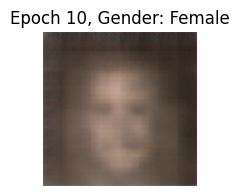

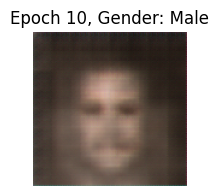

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - gender_loss: 1.3266 - kl_loss: 0.0727 - loss: 0.0772 - reconstruction_loss: 0.0566
Epoch 11/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - gender_loss: 1.2547 - kl_loss: 0.0790 - loss: 0.0721 - reconstruction_loss: 0.0517
Epoch 12/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - gender_loss: 1.2609 - kl_loss: 0.0864 - loss: 0.0710 - reconstruction_loss: 0.0498
Epoch 13/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - gender_loss: 1.2064 - kl_loss: 0.0833 - loss: 0.0707 - reconstruction_loss: 0.0504
Epoch 14/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - gender_loss: 1.1765 - kl_loss: 0.0792 - loss: 0.0669 - reconstruction_loss: 0.0471
Epoch 15/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - gender_loss: 1.1405 - kl_loss: 0.0874 - loss: 0.0680 - reconstruction_loss: 0.0478
Epoch 16/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - gender_loss: 1.1286 - kl_loss: 0.0874 - loss: 0.0659 - reconstruction_loss: 0.0458
Epoch 17/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms

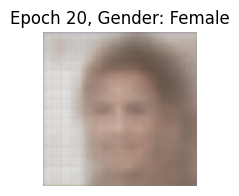

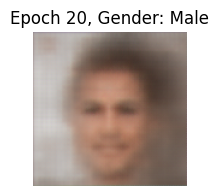

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - gender_loss: 1.0196 - kl_loss: 0.0887 - loss: 0.0649 - reconstruction_loss: 0.0457
Epoch 21/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - gender_loss: 1.0000 - kl_loss: 0.0847 - loss: 0.0653 - reconstruction_loss: 0.0467
Epoch 22/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - gender_loss: 0.9892 - kl_loss: 0.0916 - loss: 0.0634 - reconstruction_loss: 0.0442
Epoch 23/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - gender_loss: 0.9868 - kl_loss: 0.0923 - loss: 0.0637 - reconstruction_loss: 0.0449
Epoch 24/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - gender_loss: 0.9757 - kl_loss: 0.0874 - loss: 0.0637 - reconstruction_loss: 0.0450
Epoch 25/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - gender_loss: 0.9788 - kl_loss: 0.0882 - loss: 0.0636 - reconstruction_loss: 0.0450
Epoch 26/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - gender_loss: 0.9840 - kl_loss: 0.0944 - loss: 0.0640 - reconstruction_loss: 0.0447
Epoch 27/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms

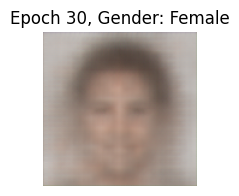

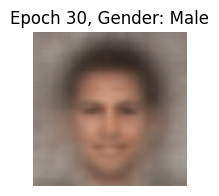

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - gender_loss: 0.9795 - kl_loss: 0.0876 - loss: 0.0622 - reconstruction_loss: 0.0438
Epoch 31/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - gender_loss: 0.9772 - kl_loss: 0.0909 - loss: 0.0621 - reconstruction_loss: 0.0432
Epoch 32/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - gender_loss: 0.9766 - kl_loss: 0.0913 - loss: 0.0619 - reconstruction_loss: 0.0430
Epoch 33/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - gender_loss: 0.9779 - kl_loss: 0.0894 - loss: 0.0627 - reconstruction_loss: 0.0440
Epoch 34/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - gender_loss: 0.9764 - kl_loss: 0.0947 - loss: 0.0624 - reconstruction_loss: 0.0431
Epoch 35/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - gender_loss: 0.9774 - kl_loss: 0.0939 - loss: 0.0621 - reconstruction_loss: 0.0431
Epoch 36/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - gender_loss: 0.9755 - kl_loss: 0.0963 - loss: 0.0617 - reconstruction_loss: 0.0422
Epoch 37/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms

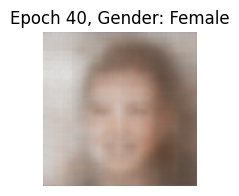

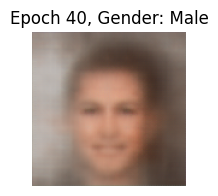

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - gender_loss: 0.9733 - kl_loss: 0.0959 - loss: 0.0608 - reconstruction_loss: 0.0414
Epoch 41/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - gender_loss: 0.9784 - kl_loss: 0.0979 - loss: 0.0618 - reconstruction_loss: 0.0423
Epoch 42/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - gender_loss: 0.9756 - kl_loss: 0.1002 - loss: 0.0607 - reconstruction_loss: 0.0412
Epoch 43/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - gender_loss: 0.9828 - kl_loss: 0.1011 - loss: 0.0617 - reconstruction_loss: 0.0420
Epoch 44/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - gender_loss: 0.9766 - kl_loss: 0.1019 - loss: 0.0619 - reconstruction_loss: 0.0420
Epoch 45/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - gender_loss: 0.9763 - kl_loss: 0.0988 - loss: 0.0609 - reconstruction_loss: 0.0414
Epoch 46/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - gender_loss: 0.9758 - kl_loss: 0.0966 - loss: 0.0616 - reconstruction_loss: 0.0424
Epoch 47/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms

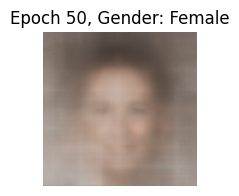

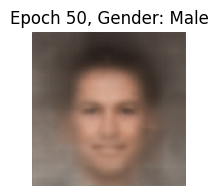

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - gender_loss: 0.9776 - kl_loss: 0.0978 - loss: 0.0617 - reconstruction_loss: 0.0422
Epoch 51/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - gender_loss: 0.9793 - kl_loss: 0.1021 - loss: 0.0618 - reconstruction_loss: 0.0418
Epoch 52/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - gender_loss: 0.9806 - kl_loss: 0.1017 - loss: 0.0612 - reconstruction_loss: 0.0414
Epoch 53/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - gender_loss: 0.9776 - kl_loss: 0.1006 - loss: 0.0602 - reconstruction_loss: 0.0404
Epoch 54/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - gender_loss: 0.9781 - kl_loss: 0.1048 - loss: 0.0613 - reconstruction_loss: 0.0411
Epoch 55/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - gender_loss: 0.9741 - kl_loss: 0.1081 - loss: 0.0618 - reconstruction_loss: 0.0412
Epoch 56/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - gender_loss: 0.9788 - kl_loss: 0.1039 - loss: 0.0597 - reconstruction_loss: 0.0397
Epoch 57/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms

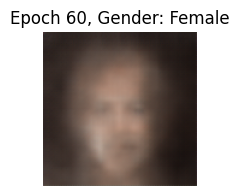

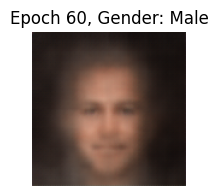

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - gender_loss: 0.9755 - kl_loss: 0.0982 - loss: 0.0605 - reconstruction_loss: 0.0409
Epoch 61/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - gender_loss: 0.9721 - kl_loss: 0.1054 - loss: 0.0604 - reconstruction_loss: 0.0402
Epoch 62/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - gender_loss: 0.9804 - kl_loss: 0.1028 - loss: 0.0601 - reconstruction_loss: 0.0401
Epoch 63/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - gender_loss: 0.9798 - kl_loss: 0.1079 - loss: 0.0605 - reconstruction_loss: 0.0398
Epoch 64/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - gender_loss: 0.9750 - kl_loss: 0.1044 - loss: 0.0601 - reconstruction_loss: 0.0398
Epoch 65/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - gender_loss: 0.9752 - kl_loss: 0.1040 - loss: 0.0605 - reconstruction_loss: 0.0404
Epoch 66/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - gender_loss: 0.9765 - kl_loss: 0.1054 - loss: 0.0594 - reconstruction_loss: 0.0391
Epoch 67/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms

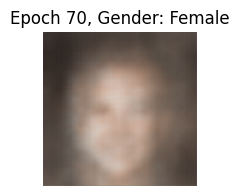

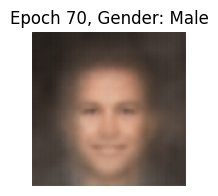

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - gender_loss: 0.9788 - kl_loss: 0.1055 - loss: 0.0596 - reconstruction_loss: 0.0394
Epoch 71/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - gender_loss: 0.9798 - kl_loss: 0.1105 - loss: 0.0617 - reconstruction_loss: 0.0408
Epoch 72/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - gender_loss: 0.9779 - kl_loss: 0.1068 - loss: 0.0596 - reconstruction_loss: 0.0392
Epoch 73/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - gender_loss: 0.9798 - kl_loss: 0.1069 - loss: 0.0603 - reconstruction_loss: 0.0400
Epoch 74/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - gender_loss: 0.9804 - kl_loss: 0.1030 - loss: 0.0602 - reconstruction_loss: 0.0401
Epoch 75/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - gender_loss: 0.9803 - kl_loss: 0.1019 - loss: 0.0601 - reconstruction_loss: 0.0403
Epoch 76/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - gender_loss: 0.9806 - kl_loss: 0.1110 - loss: 0.0608 - reconstruction_loss: 0.0399
Epoch 77/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms

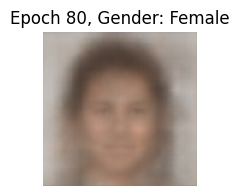

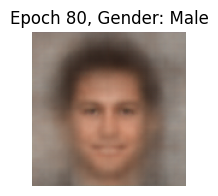

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - gender_loss: 0.9781 - kl_loss: 0.1073 - loss: 0.0599 - reconstruction_loss: 0.0394
Epoch 81/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - gender_loss: 0.9783 - kl_loss: 0.1061 - loss: 0.0594 - reconstruction_loss: 0.0391
Epoch 82/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - gender_loss: 0.9769 - kl_loss: 0.1099 - loss: 0.0588 - reconstruction_loss: 0.0381
Epoch 83/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - gender_loss: 0.9786 - kl_loss: 0.1094 - loss: 0.0591 - reconstruction_loss: 0.0384
Epoch 84/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - gender_loss: 0.9765 - kl_loss: 0.1082 - loss: 0.0589 - reconstruction_loss: 0.0381
Epoch 85/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - gender_loss: 0.9757 - kl_loss: 0.1073 - loss: 0.0592 - reconstruction_loss: 0.0388
Epoch 86/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - gender_loss: 0.9749 - kl_loss: 0.1131 - loss: 0.0598 - reconstruction_loss: 0.0387
Epoch 87/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms

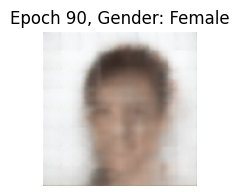

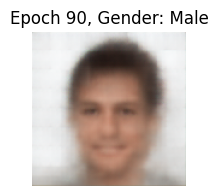

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - gender_loss: 0.9764 - kl_loss: 0.1119 - loss: 0.0605 - reconstruction_loss: 0.0396
Epoch 91/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - gender_loss: 0.9825 - kl_loss: 0.1070 - loss: 0.0591 - reconstruction_loss: 0.0386
Epoch 92/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - gender_loss: 0.9775 - kl_loss: 0.1124 - loss: 0.0604 - reconstruction_loss: 0.0394
Epoch 93/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - gender_loss: 0.9754 - kl_loss: 0.1136 - loss: 0.0595 - reconstruction_loss: 0.0386
Epoch 94/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - gender_loss: 0.9788 - kl_loss: 0.1126 - loss: 0.0601 - reconstruction_loss: 0.0391
Epoch 95/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - gender_loss: 0.9799 - kl_loss: 0.1088 - loss: 0.0596 - reconstruction_loss: 0.0390
Epoch 96/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - gender_loss: 0.9739 - kl_loss: 0.1063 - loss: 0.0593 - reconstruction_loss: 0.0389
Epoch 97/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms

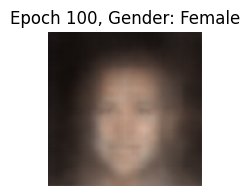

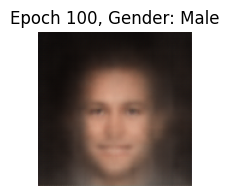

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - gender_loss: 0.9749 - kl_loss: 0.1131 - loss: 0.0603 - reconstruction_loss: 0.0391


In [178]:
# Create CVAE model
cvae = CVAE(encoder, decoder, variational=True)

# Initialise callbacks
history_callback = LossHistoryCallback() # To save the loss
gen_callback = GenerateImageCallback(decoder, latent_dim=latent_dim, epoch_interval=10) # To see the quality of the imaes we generate at every 10 epochs

# Model compiling and training
cvae.compile(optimizer=keras.optimizers.Adam(clipnorm=1.0))
cvae.fit(x_t, y_train, epochs=100, batch_size=32, callbacks=[history_callback, gen_callback])

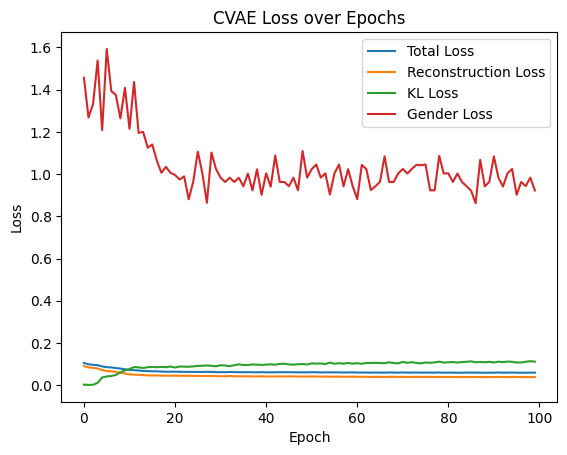

In [179]:
# Plot the loss as graphic
# import matplotlib.pyplot as plt

plt.plot(total_loss_history, label="Total Loss")
plt.plot(reconstruction_loss_history, label="Reconstruction Loss")
plt.plot(kl_loss_history, label="KL Loss")
plt.plot(gender_loss_history, label="Gender Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("CVAE Loss over Epochs")
plt.show()

Le loss est décroissant en général, reconstruction loss toujours en diminution, KL loss et gender loss sont déjà bien convergents.

In [180]:
z_mean, _, _, _ = cvae.encoder.predict([x_test, y_test], batch_size=32)

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 223ms/step


In [181]:
import numpy as np

nan_rows = np.any(np.isnan(z_mean), axis=1)
print(f"Nb of samples containing NaN : {np.sum(nan_rows)} / {len(z_mean)}")


Nb of samples containing NaN : 0 / 330


In [182]:
print(z_mean[:1])

[[-0.07587168 -0.07834312  0.16922055  0.02662546  0.10116413 -0.08037056
  -0.01003155 -0.9644754   0.04308543  0.14809816 -0.3711954   0.04284908
   0.01838209 -0.08907001  0.02937261 -0.05717887  0.02515231 -0.08089881
   0.05342518 -0.47888362 -0.10519488 -0.03213831 -0.10616261  0.03706634
  -0.00799153 -0.05349953 -0.02482095 -0.03438828  0.06689528 -0.05217952
  -0.00179631 -0.00712603]]


In [183]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
# z_fixed = np.nan_to_num(z_mean, nan=0.0)  # replace all NaN by 0.0


# t-SNE (for decreasing the dimension, can also use PCA)
z_2d = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(z_mean)


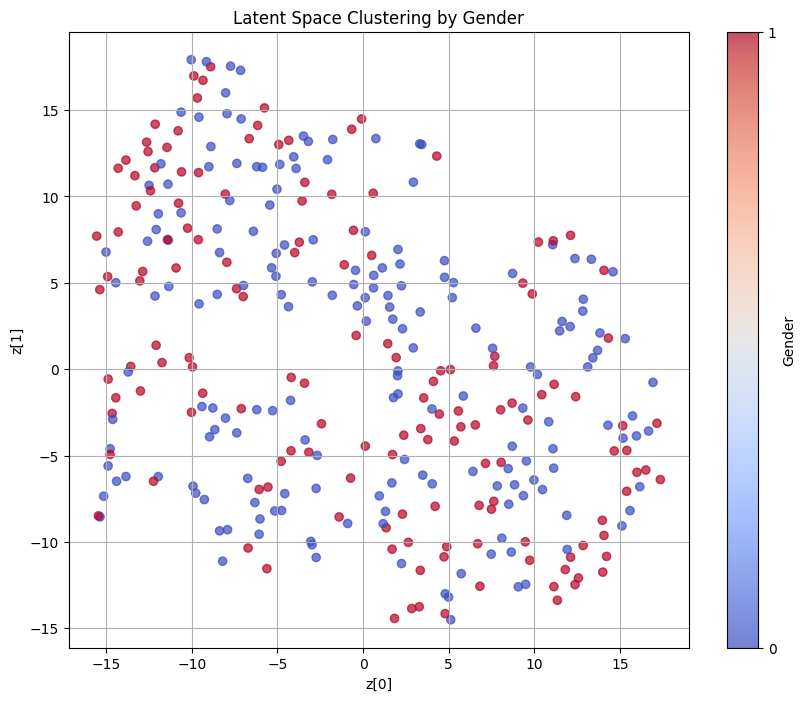

In [184]:
y_colormap = (y_test.flatten() + 1) // 2

plt.figure(figsize=(10, 8))
scatter = plt.scatter(z_2d[:, 0], z_2d[:, 1], c=y_colormap, cmap="coolwarm", alpha=0.7)
plt.colorbar(scatter, ticks=[0, 1], label="Gender")
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.title("Latent Space Clustering by Gender")
plt.grid(True)
plt.show()

# The gender clusters are not well seperated, but I tried to generate male/female images and it seems to be not bad...

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


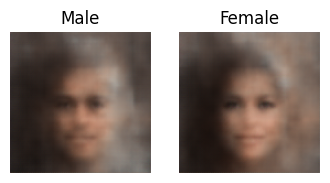

In [185]:
import numpy as np
import matplotlib.pyplot as plt

# generate a random latent z
z_sample = np.random.normal(size=(1, latent_dim))

# condition label：-1 = female，1 = male
label_male = np.array([[1]])
label_female = np.array([[-1]])

# generate male/female image
img_male = cvae.decoder.predict([z_sample, label_male])
img_female = cvae.decoder.predict([z_sample, label_female])

plt.figure(figsize=(4, 2))
plt.subplot(1, 2, 1)
plt.title("Male")
plt.imshow(img_male[0])
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Female")
plt.imshow(img_female[0])
plt.axis('off')
plt.show()